In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys

sys.path.append('/data/yosef2/users/chenling/scVI/')
import scvi
print(scvi.__version__)

import os
os.getcwd()

0.5.0


'/data/yosef2/users/chenling/TabulaSapiens/CompartmentSplit/notebooks'

In [2]:
import logging
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hyperopt import hp

from scvi.inference import UnsupervisedTrainer, AlternateSemiSupervisedTrainer, SemiSupervisedTrainer
from scvi.models import VAE, SCANVI

from scvi.dataset.anndataset import AnnDatasetFromAnnData
import scanpy as sc
from anndata import read_h5ad
from anndata import AnnData

import matplotlib

In [3]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [8]:
n_epochs = 150
save_path = '../../AnnotationsRound1/data/'
show_plot = True
test_mode = False
use_batches = True
use_cuda = True
lr = 1e-3
retrain=True

In [9]:
tissue = 'lung'
capital_tissue = tissue[0].upper()+tissue[1:]

In [10]:
tenx = read_h5ad(save_path + 'tabula-sapiens-10X-pilot-filtered-%s.h5ad'%tissue)

In [11]:
save_path + 'tabula-sapiens-10X-pilot-filtered-%s.h5ad'%tissue

'../../AnnotationsRound1/data/tabula-sapiens-10X-pilot-filtered-lung.h5ad'

In [12]:
ss2 = read_h5ad(save_path + 'tabula-sapiens-facs-pilot-filtered-%s.h5ad'%capital_tissue)

In [13]:
save_path + 'tabula-sapiens-facs-pilot-filtered-%s.h5ad'%capital_tissue

'../../AnnotationsRound1/data/tabula-sapiens-facs-pilot-filtered-Lung.h5ad'

In [14]:
adata = tenx.concatenate(ss2)

In [15]:
data = AnnDatasetFromAnnData(adata, batch_label='batch')

[2019-12-06 12:51:16,454] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-06 12:51:16,457] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-06 12:51:16,585] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 12:51:16,714] INFO - scvi.dataset.dataset | Downsampled from 20414 to 20414 cells


In [16]:
data.subsample_genes(5000)

[2019-12-06 12:51:16,720] INFO - scvi.dataset.dataset | extracting highly variable genes


Transforming to str index.


[2019-12-06 12:51:28,348] INFO - scvi.dataset.dataset | Downsampling from 21301 to 5000 genes
[2019-12-06 12:51:28,542] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 12:51:28,574] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2019-12-06 12:51:28,599] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-06 12:51:28,625] INFO - scvi.dataset.dataset | Downsampled from 20414 to 20414 cells


### This took about 7 minutes to train

In [19]:
vae = VAE(data.nb_genes, n_batch=data.n_batches * use_batches,
          n_layers=2, n_latent=30, dispersion='gene')
trainer = UnsupervisedTrainer(
    vae,
    data,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
    data_loader_kwargs={"pin_memory":False} 
)

In [20]:
filename = '%s/vae.%s10xfacs.pkl'%(save_path,tissue)

if retrain==True:
    torch.manual_seed(0)
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), filename)

else:

    if os.path.isfile(filename):
        trainer.model.load_state_dict(torch.load(filename))
        trainer.model.eval()
    else:
        trainer.train(n_epochs=n_epochs, lr=lr)
        torch.save(trainer.model.state_dict(), filename)

# code for plotting elbo for training and testing data

(1000, 2000)

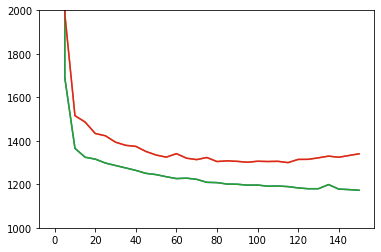

In [21]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 150, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(3000, 11000)

elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 150, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1000, 2000)

In [22]:
posterior = trainer.create_posterior(
        trainer.model, data, indices=np.arange(len(data))
    ).sequential()

latent, _, _ = posterior.get_latent()


# get imputed gene expression values

In [23]:
# imputed_values = posterior.sequential().imputation()
# normalized_values = posterior.sequential().get_sample_scale()

# using scVI latent space in scanpy

In [24]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [25]:
adata.obsm["X_scvi"] = latent
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, use_rep="X_scvi")
sc.tl.umap(adata)

sc.tl.louvain(adata, key_added="louvain_scvi", resolution=1)

In [26]:
adata.obs.columns

Index(['10X_plate', 'BA_nM', 'NovaSeqRun', 'additional_notes',
       'anatomical_position', 'barcode', 'batch', 'bead_cleanup',
       'cDNA_dilute', 'cDNA_prep_person', 'excluded', 'investigator',
       'lib_prep_date', 'library_prep', 'method', 'n_genes', 'plate',
       'primary_sort', 'sex', 'sort_direction', 'sort_order', 'subjectid',
       'tissue', 'well', 'well_group', 'louvain_scvi'],
      dtype='object')

... storing '10X_plate' as categorical
... storing 'BA_nM' as categorical
... storing 'NovaSeqRun' as categorical
... storing 'additional_notes' as categorical
... storing 'anatomical_position' as categorical
... storing 'barcode' as categorical
... storing 'bead_cleanup' as categorical
... storing 'cDNA_dilute' as categorical
... storing 'cDNA_prep_person' as categorical
... storing 'excluded' as categorical
... storing 'investigator' as categorical
... storing 'lib_prep_date' as categorical
... storing 'library_prep' as categorical
... storing 'method' as categorical
... storing 'plate' as categorical
... storing 'primary_sort' as categorical
... storing 'sex' as categorical
... storing 'sort_direction' as categorical
... storing 'sort_order' as categorical
... storing 'subjectid' as categorical
... storing 'tissue' as categorical
... storing 'well' as categorical
... storing 'well_group' as categorical


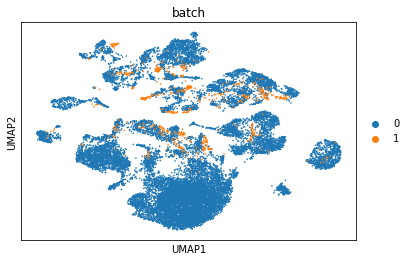

In [27]:
sc.pl.umap(adata, color=['batch'],s=10)

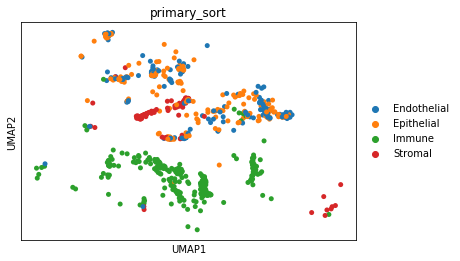

In [28]:
sc.pl.umap(adata[adata.obs['batch']=='1',:], color=['primary_sort'],s=100)

# Epithelium
|Cell type | prop|number | marker genes|
|-----|-----|-----|--|
|Club Cell|0.5|1500|CYP2F2, SCGB3A2, CCKAR|
|Ciliated Cell|2|6000|FOXJ1, TUBB1, TP73, CCDC78|
|Basal Cell|0.5|1500|KRT5, KRT14, TP63, DAPL1|
|Goblet Cell|0.2|500|MUC5B, MUC5AC, SPDEF|
|Mucous Cell|0.03|80|MUC5B|
|Serous Cell|0.03|80|PRR4, LPO, LTF|
|Ionocyte|0.03|100|CFTR, FOXI1, ASCL3|
|Neuroendocrine Cell|0.01|40|CALCA, CHGA, ASCL1|
|Tuft Cell|0.1|200|DCLK1, ASCL2|
|Alveolar Epithelial Type 1 Cell|13|40000|AGER, PDPN, CLIC5|
|Alveolar Epithelial Type 2 Cell|7|20000|SFTPB, SFTPC, SFTPD, MUC1, ETV5|


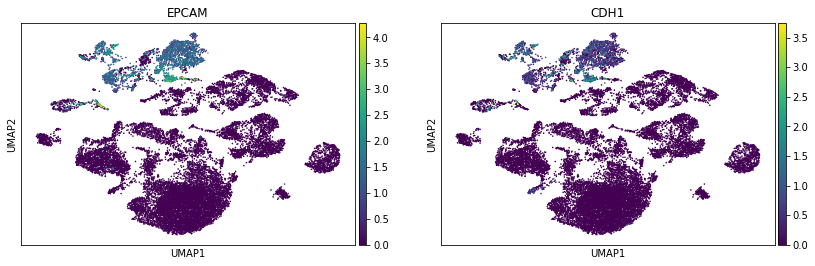

In [40]:
sc.pl.umap(adata, color=['EPCAM', 'CDH1'],s=10)

# Endothelium

|Cell type | prop|number | marker genes|
|-----|-----|-----|--|
|Artery Cell|1|3000|GJA5, BMX|
|Vein Cell|1|3000|ACKR1|
|Capillary Cell|23|70000|CA4|
|Bronchial Vessel|0.7|2000||
|Lymphatic Cell|0.7|2000|PROX1, PDPN|


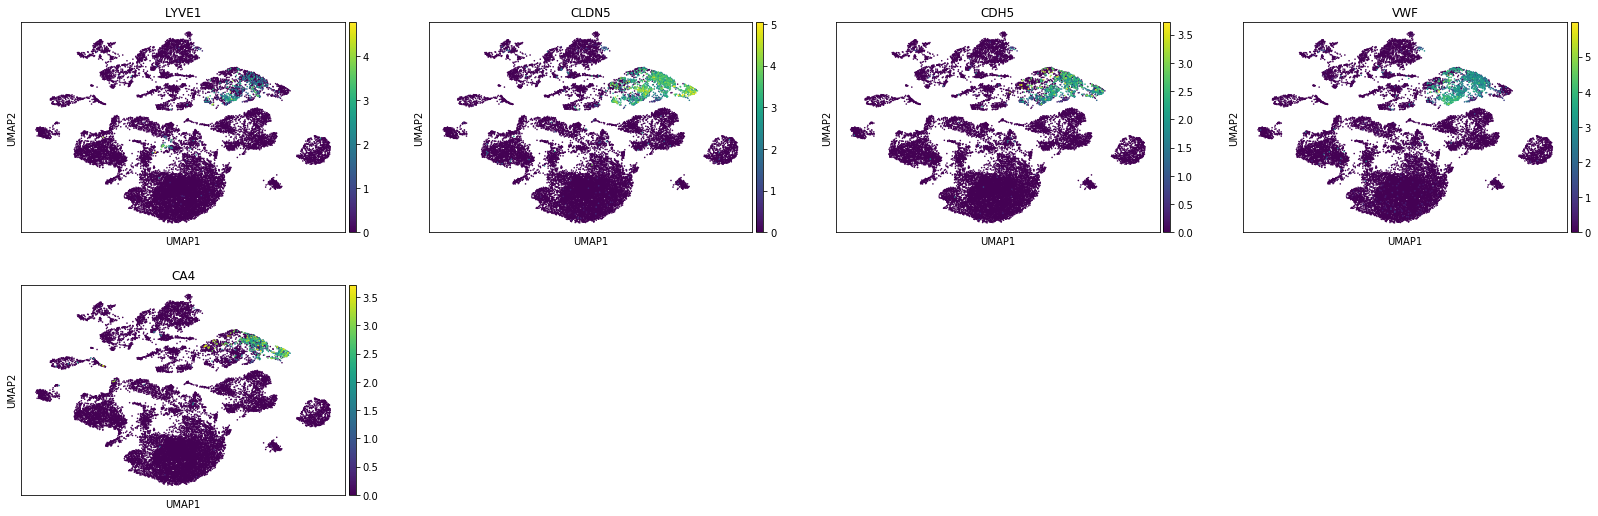

In [39]:
# sc.pl.umap(adata, color=['VWF','NOTCH1' ,'ACKR1','LYVE1','CA4'],s=10)
sc.pl.umap(adata, color=['LYVE1','CLDN5','CDH5','VWF','CA4'],s=10)

# Stroma	
|Cell type | prop|number | marker genes|
|-----|-----|-----|--|
|Vascular Smooth Muscle|2|5000|CNN1, ACTA2, TAGLN, NOTCH3, LGR5|
|Airway Smooth Muscle|1|4000|CNN1, ACTA2, TAGLN, DES, LGR6|
|Fibroblast|7|20000|COL1A1, PDGFRA|
|Myofibroblast|7|20000|COL1A1, PDGFRA, ELN, ACTA2|
|Lipofibroblast|7|20000|COL1A1, PDGFRA, PLIN2, APOE|
|Pericyte|7|20000|CSPG4, TRPC6, PDGFRB|
|Mesothelial Cell|0.3|1000|MSLN, UPK3B, WT1|


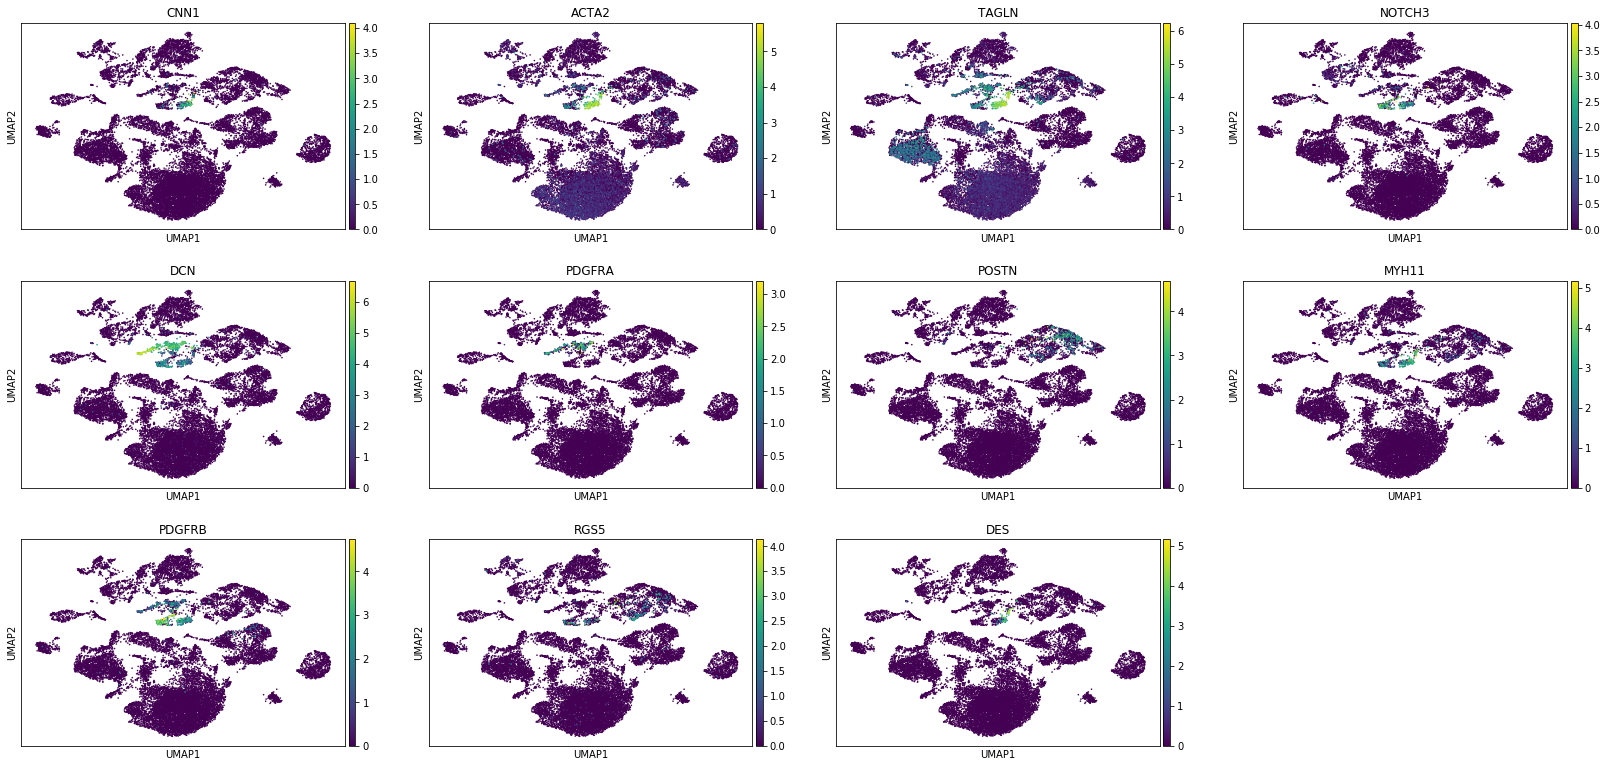

In [41]:
sc.pl.umap(adata, color=['CNN1','ACTA2' ,'TAGLN','NOTCH3','DCN','PDGFRA' ,'POSTN','MYH11','PDGFRB','RGS5','DES'],s=10)

# PNS
|Cell type | number | marker genes|
|-----|-----|-------|
|Intrinsic Neuron (parasymphatetic)	| |VIP, NOS, NPY|
|Neuroendocrine| | |			
|Schwann	| |GAP43, MPZ|


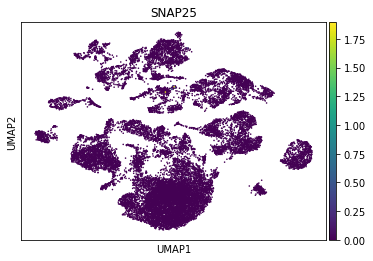

In [43]:
sc.pl.umap(adata, color=['SNAP25'],s=10)

# Immune
|Cell type  | marker genes|
|-----|-------|
|B cell	|CD79a, CD24, MS4A1, CD19|
|Plasma Cell	|CD79a, CD27|
|CD8+ memory T cell	|CD3E, CD8|
|CD8+ naïve T cell	|CD3E, CD8|
|CD4+ memory T cell	|CD3E, CD4|
|CD4+ naïve T cell	|CD3E, CD4|
|NK cell	|KLRD1, NKG7|
|NKT cell	|CD3E, KLR1B, FCER1G|
|Neurtophil	|S100A8, S100A9, IFITM2, FCGR3B|
|Basophil	|MS4A2, CPA3, TPSAB1|
|Mast cell	|MS4A2, CPA3, TPSAB1|
|Eosinophil	|SIGLEC8|
|Megakaryocyte	|NRGN, PPBP, PF4, OST4|
|Macrophage	|CD163, MARCO, MSR1, MRC1|
|pDC	|LILRB4, IRF8, LILRA4|
|mDC1	|CD1, CLED9A, LAMP3|
|mDC2	|CD1, PKIIB|
|Classical Monocyte	|CD14, CD16|
|Nonclassical monocyte	|CD163, MARCO, MSR1, MRC1|

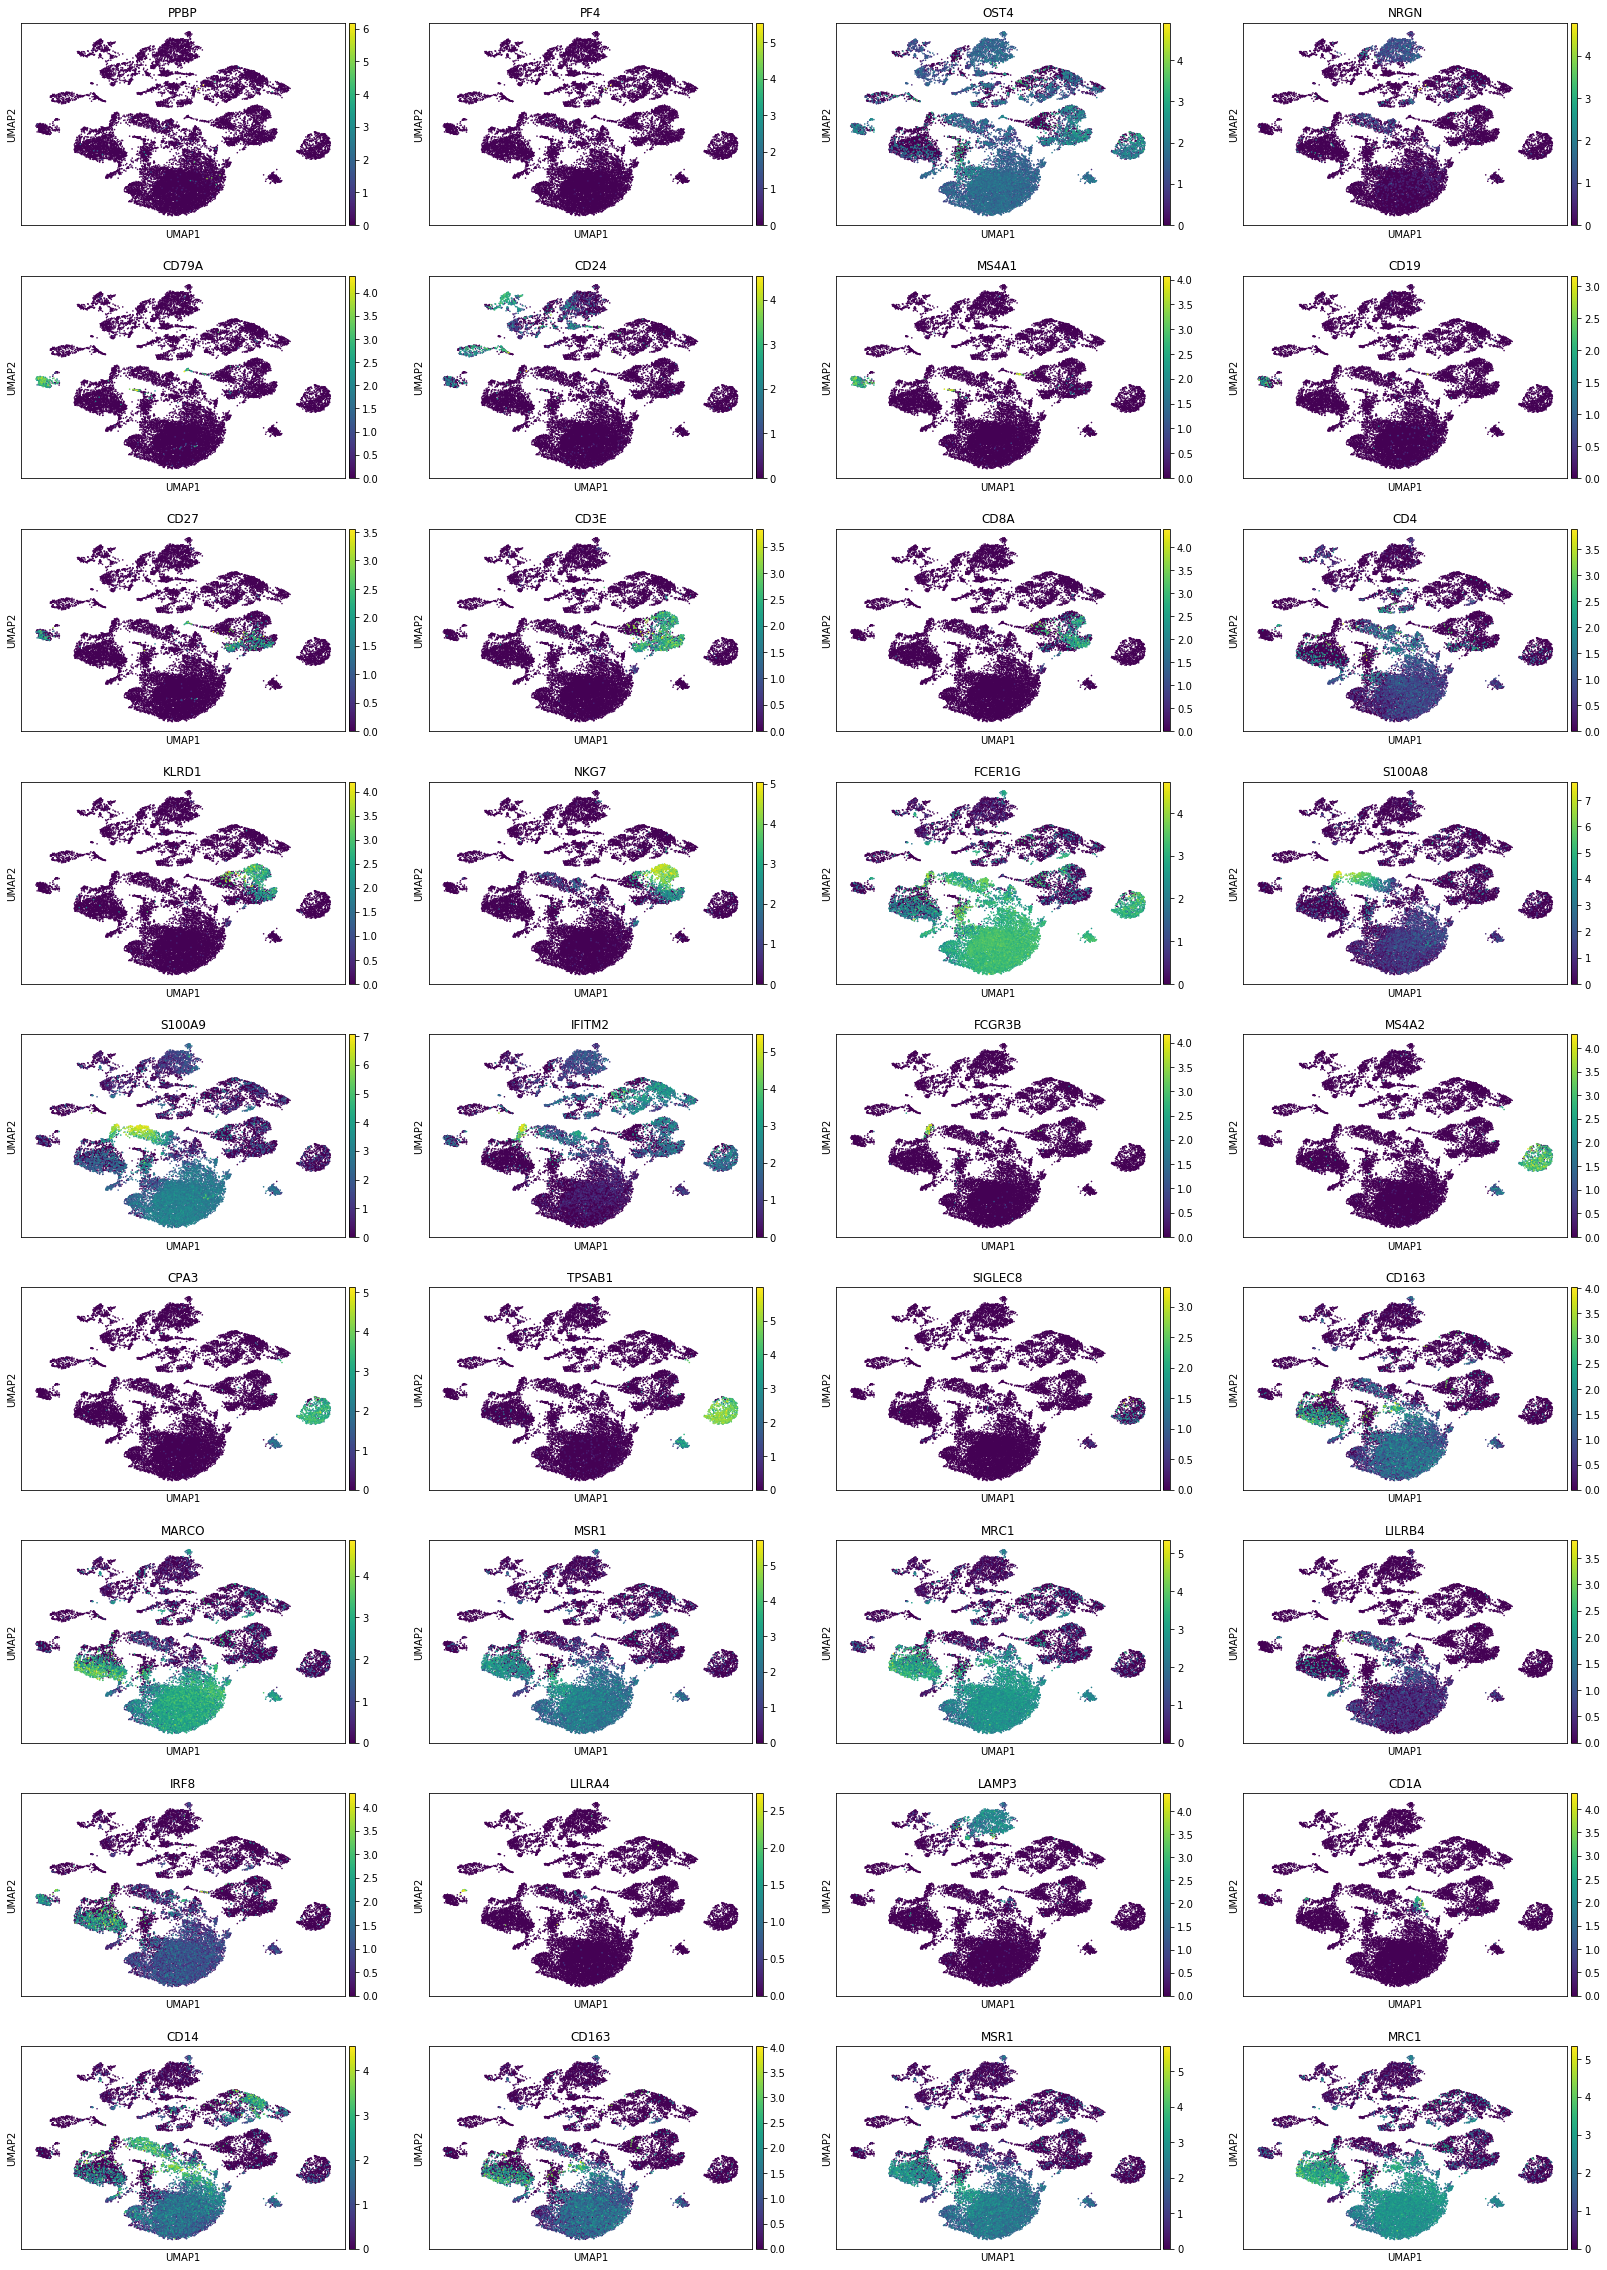

In [44]:
genelist = ['PPBP','PF4','OST4','NRGN',
            'CD79A','CD24','MS4A1','CD19',
           'CD27','CD3E','CD8A','CD4','KLRD1','NKG7','FCER1G',
           'S100A8','S100A9','IFITM2','FCGR3B',
           'MS4A2','CPA3','TPSAB1','SIGLEC8','CD163','MARCO','MSR1','MRC1',
           'LILRB4','IRF8','LILRA4','LAMP3','CD1A','CD14',
           'CD163','MSR1','MRC1']
sc.pl.umap(adata, color=genelist,s=10)

In [45]:
# pancreas contamination

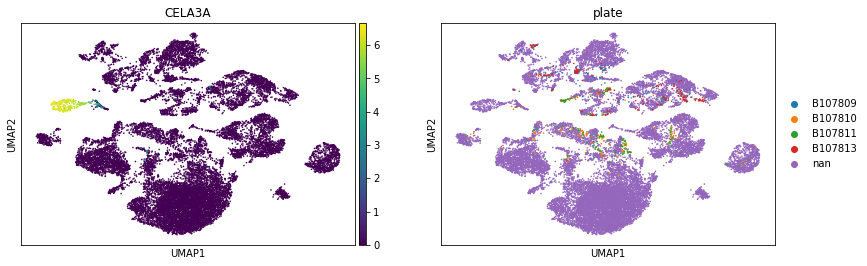

In [46]:
genelist = ['CELA3A','plate']
sc.pl.umap(adata, color=genelist,s=10)

# use scANVI to split compartment, then perform leiden clustering on each compartment

In [30]:
data.cell_types

array(['undefined'], dtype='<U128')

In [31]:
data.cell_types, data.labels = np.unique(adata.obs['primary_sort'].values, return_inverse=True)
data.labels = data.labels.reshape(len(data.labels),1)
data.n_labels = len(data.cell_types)

In [32]:
np.unique(data.batch_indices,return_counts=True)

(array([0, 1], dtype=uint16), array([19684,   730]))

In [33]:
scanvi = SCANVI(data.nb_genes, data.n_batches, data.n_labels, n_layers=2,n_latent=30)
scanvi.load_state_dict(posterior.model.state_dict(), strict=False)
trainer_scanvi = AlternateSemiSupervisedTrainer(scanvi, data, classification_ratio=0,
                                                n_epochs_classifier=100, lr_classification=5 * 1e-3)

nan_idx = list(data.cell_types).index('nan')
islabelled = np.logical_and((data.batch_indices.ravel() == 1), data.labels.ravel()!= nan_idx )
notlabelled = np.logical_or((data.batch_indices.ravel() == 0), data.labels.ravel()== nan_idx )

labelled = np.where(islabelled)[0]
labelled = np.random.choice(labelled, len(labelled), replace=False)
trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=notlabelled)
trainer_scanvi.train(n_epochs=3)

full = trainer_scanvi.create_posterior(trainer_scanvi.model, data, indices=np.arange(len(data)))
_, labels_pred = full.sequential().compute_predictions()

In [34]:
adata.obs['compartment_pred'] = data.cell_types[labels_pred]

# color by predicted compartments

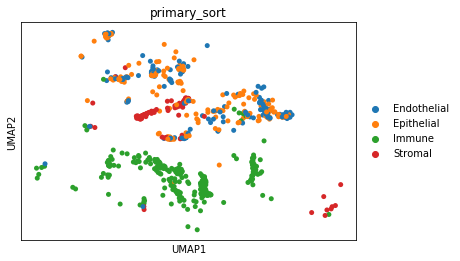

In [47]:
sc.pl.umap(adata[adata.obs['batch']=='1',:], color=['primary_sort'],s=100)

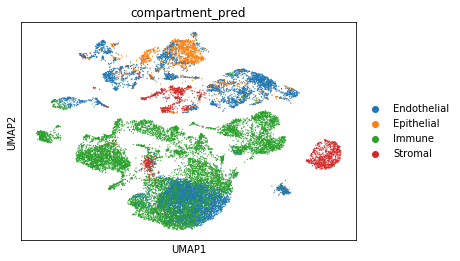

In [48]:
sc.pl.umap(adata, color=['compartment_pred'],ncols=1)

# seed labeling with compartment markers

In [52]:
compartments = {'Epithelial':['EPCAM', 'CDH1'], 
                'Endothelial':['LYVE1','CLDN5','CDH5','VWF','CA4'],
                'Stromal':['ACTA2' ,'DCN','PDGFRA'],
               'Immune':['PTPRC','RAC2','LCP1'] ,
               'PNS':['SNAP25'],
               'Pancreas':['CELA3A']}

In [53]:
for x in compartments.keys():
    sc.tl.score_genes(adata, ctrl_size=100, gene_list=compartments[x],score_name = x)

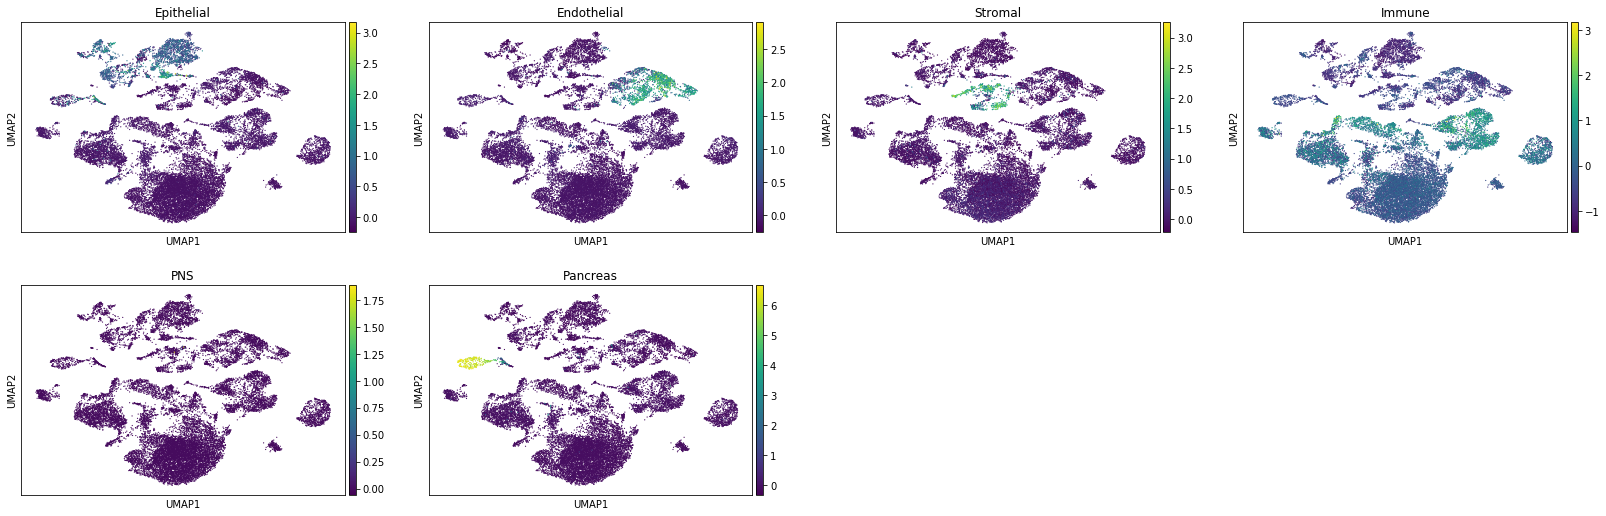

In [54]:
sc.pl.umap(adata, color=compartments.keys())

In [75]:
for x in compartments.keys():
    indicator = x+'_label'
    # compute gene signature scores
    sc.tl.score_genes(adata, compartments[x], score_name=x)
    cutoff = np.min(adata.obs.nlargest(500,x)[x].values)
    if x=='Epithelial':
        cutoff = np.min(adata.obs.nlargest(1000,x)[x].values)
    if x=='PNS':
        cutoff = np.min(adata.obs.nlargest(10,x)[x].values)
    if x=='Immune':
        cutoff = np.min(adata.obs.nlargest(2000,x)[x].values)
    if x=='Pancreas':
        cutoff = np.min(adata.obs.nlargest(200,x)[x].values)
    adata.obs[indicator] = (adata.obs[x].values>cutoff).astype(str)


... storing 'Epithelial_label' as categorical
... storing 'Endothelial_label' as categorical
... storing 'Stromal_label' as categorical
... storing 'Immune_label' as categorical
... storing 'PNS_label' as categorical
... storing 'Pancreas_label' as categorical


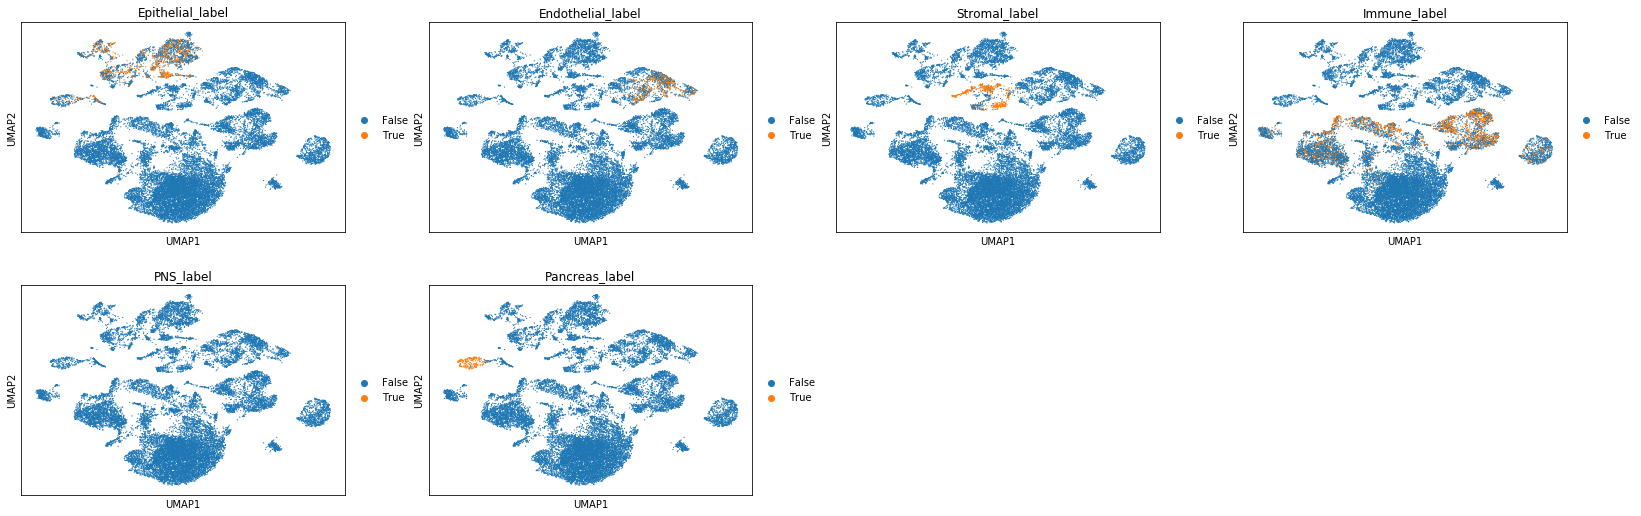

In [76]:
labelled = [x+'_label' for x in compartments.keys()]
sc.pl.umap(adata, color=labelled)

In [77]:
all_indicators = pd.concat([adata.obs[x+'_label'] for x in compartments.keys()], axis = 1)
unique_celltypes = ((all_indicators.values=='True').sum(axis=1) <=1 )

labels = np.repeat(0, data.X.shape[0])
for i, c in enumerate(compartments.keys()):
    idx = np.where(
        np.logical_and(
        unique_celltypes, 
        adata.obs[c+'_label'].values=='True'))[0]
    labels[idx] = i+1

data.cell_types = ['unlabelled']+list(compartments.keys())
data.labels = labels.reshape(len(labels),1)
data.n_labels = len(data.cell_types)

labelled = np.where(data.labels.ravel()!=0)[0]
labelled = np.random.choice(labelled, len(labelled), replace=False)

unlabelled = np.where(data.labels.ravel()==0)[0]
unlabelled = np.random.choice(unlabelled, len(unlabelled), replace=False)


In [78]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]),
 array([16309,   956,   497,   493,  1988,     5,   166]))

In [79]:

labels_pred = []
scanvi = SCANVI(data.nb_genes, data.n_batches, data.n_labels, n_layers=2,n_latent=30, symmetric_kl=True)
filename = '%s/vae.%s10xfacs.pkl'%(save_path,tissue)
scanvi.load_state_dict(torch.load(filename), strict=False)
trainer_scanvi = SemiSupervisedTrainer(scanvi, data, n_epochs_classifier=50, lr_classification=5 * 1e-3)

trainer_scanvi.labelled_set = trainer_scanvi.create_posterior(indices=labelled)
trainer_scanvi.unlabelled_set = trainer_scanvi.create_posterior(indices=unlabelled)
trainer_scanvi.train(n_epochs=15)
full = trainer_scanvi.create_posterior(trainer_scanvi.model, data, indices=np.arange(len(data)))
_, pred = full.sequential().compute_predictions()

... storing 'comp_pred' as categorical


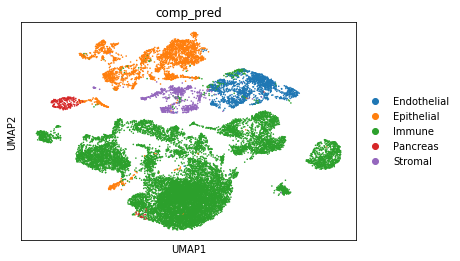

In [80]:
adata.obs['comp_pred'] = [data.cell_types[i] for i in pred]
sc.pl.umap(adata, color=['comp_pred'],  show=show_plot,size=10)

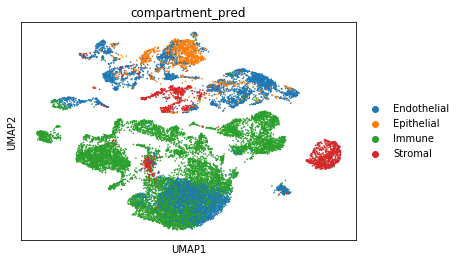

In [65]:
sc.pl.umap(adata, color=['compartment_pred'],  show=show_plot,size=10)

# plotting cell cycle changes

In [66]:
g1s_genes =  ['MCM5','PCNA','TYMS','FEN1','MCM2','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1','UHRF1','MLF1IP','HELLS','RFC2','RPA2','NASP',
         'RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7','POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
         'USP1','CLSPN','POLA1','CHAF1B','BRIP1','E2F8']

g2m_genes = ['HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B','MKI67','TMPO','CENPF','TACC3','FAM64A','SMC4','CCNB2',
        'CKAP2L','CKAP2','AURKB','BUB1','KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','HJURP','CDCA3','HN1','CDC20','TTK','CDC25C','KIF2C',
        'RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1','ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3',
        'CBX5','CENPA']


In [67]:
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_genes, g2m_genes=g2m_genes)


... storing 'phase' as categorical


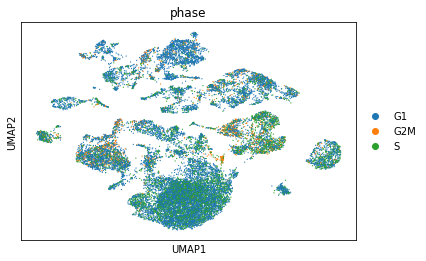

In [68]:
sc.pl.umap(adata,color=['phase'])

# differential expression

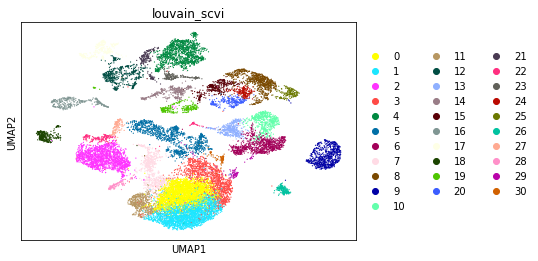

In [81]:
sc.pl.umap(adata, color=['louvain_scvi'],ncols=1)

In [82]:
sc.tl.rank_genes_groups(
    adata,
    "louvain_scvi",
    method="wilcoxon",
    use_raw=False,
    key_added="rank_genes_groups_wilcox",
    n_genes=adata.shape[1],
)

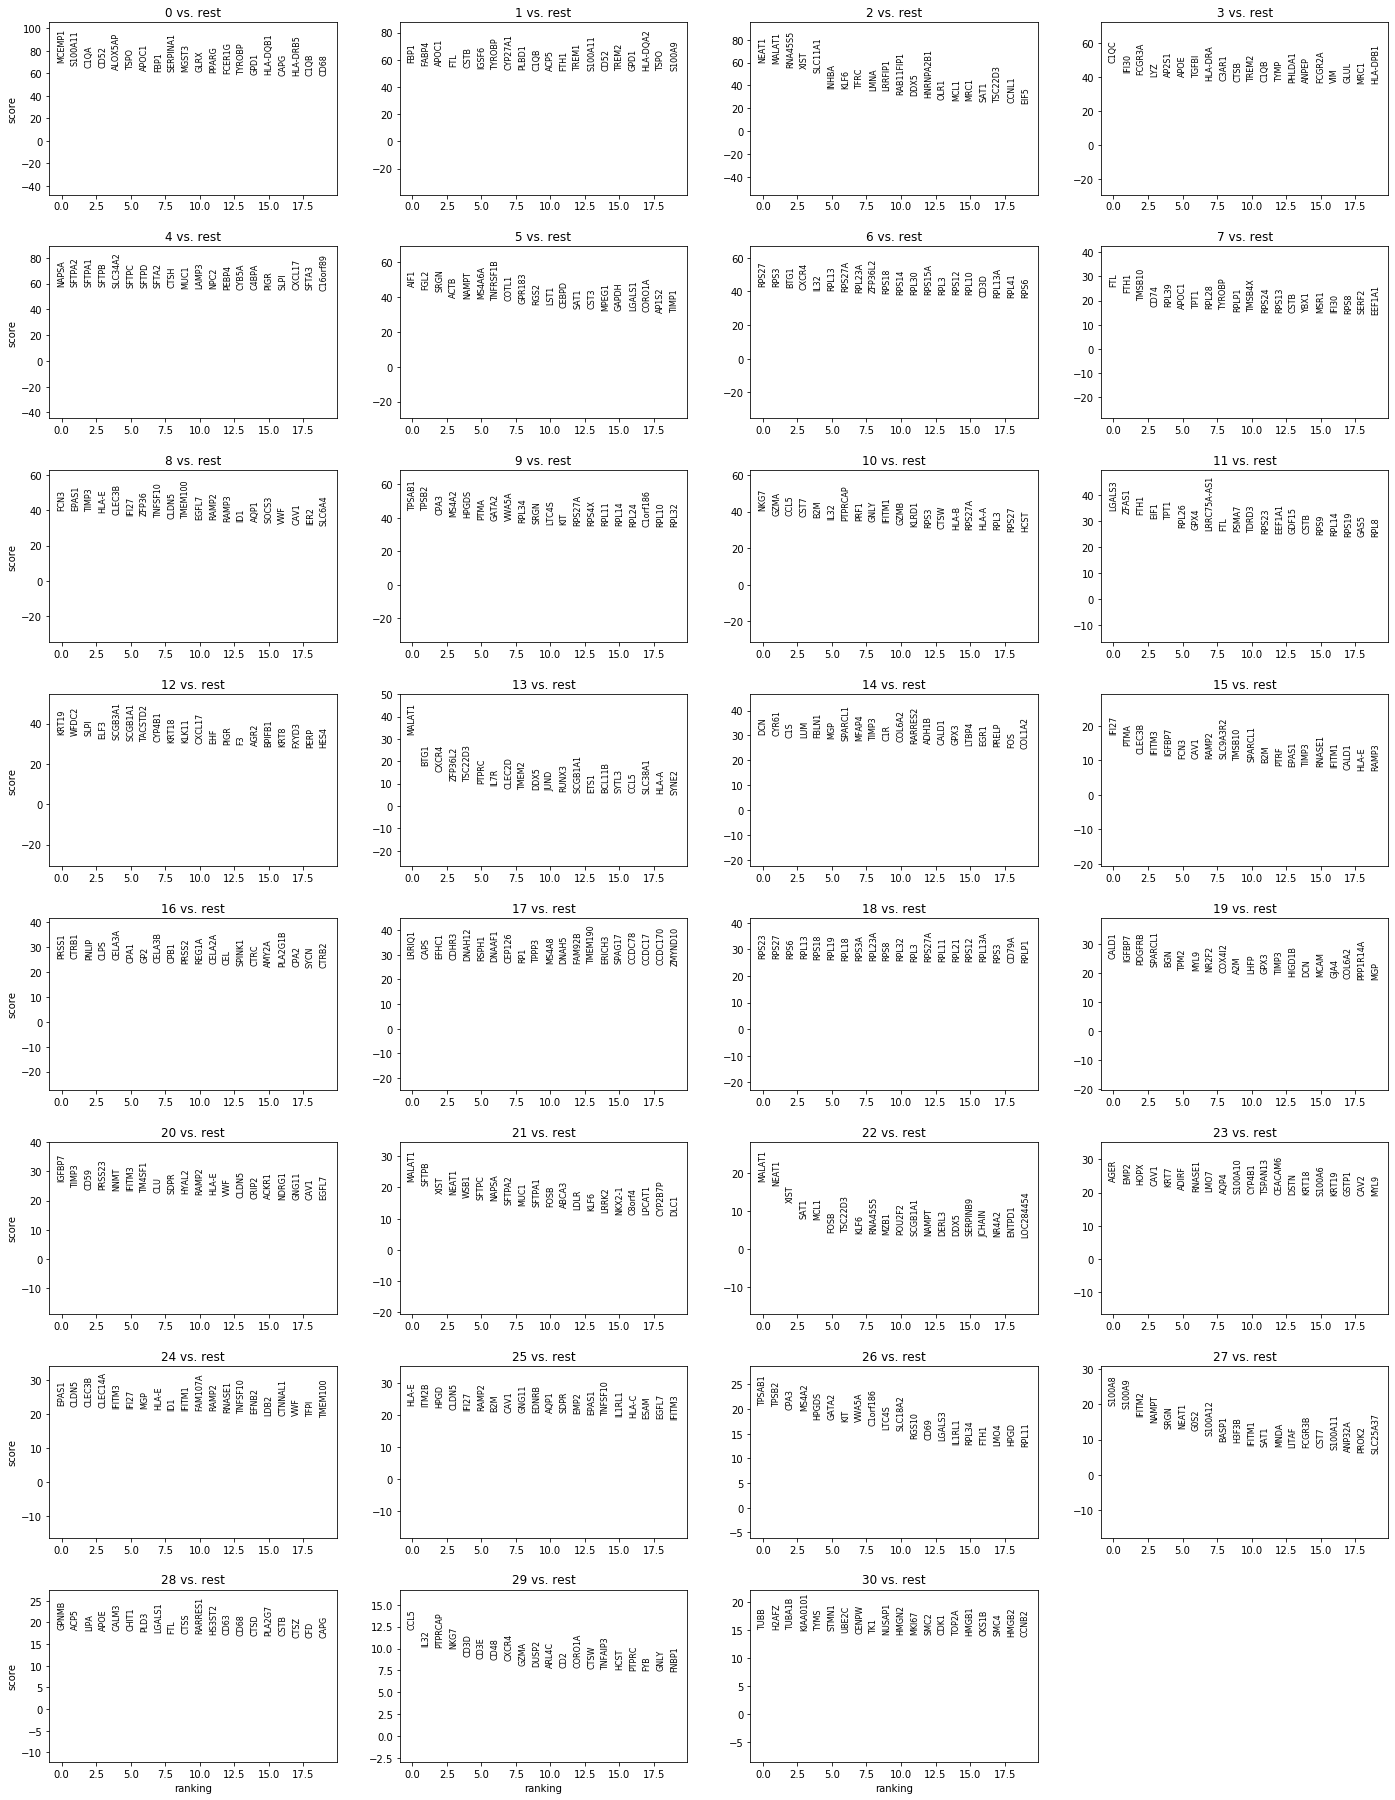

In [83]:
sc.pl.rank_genes_groups(
    adata, key="rank_genes_groups_wilcox", sharey=False
)

In [84]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
result = adata.uns['rank_genes_groups_wilcox']
groups = result['names'].dtype.names
sapiens_rank_genes_scores = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores','pvals']})
sapiens_rank_genes_scores.to_csv('%s.wilcoxon.csv'%tissue)

In [85]:
sapiens_rank_genes_scores

0_n        0_s            0_p        1_n        1_s           1_p           2_n        2_s            2_p        3_n        3_s            3_p        4_n        4_s            4_p           5_n        5_s            5_p        6_n        6_s            6_p           7_n        7_s            7_p          8_n        8_s            8_p          9_n        9_s            9_p       10_n       10_s           10_p          11_n       11_s           11_p        12_n       12_s           12_p          13_n       13_s           13_p       14_n       14_s           14_p       15_n       15_s          15_p          16_n       16_s           16_p          17_n       17_s           17_p          18_n       18_s           18_p       19_n       19_s           19_p       20_n       20_s           20_p         21_n       21_s           21_p          22_n       22_s          22_p       23_n       23_s           23_p       24_n       24_s           24_p          25_n       25_s  \
0            MCEMP1  69.954460   0.000000e+00       FBP1  58.318840  0.000000e+00         NEAT1  60.438374   0.000000e+00       C1QC  48.859844   0.000000e+00      NAPSA  58.136421   0.000000e+00          AIF1  46.337929   0.000000e+00      RPS27  43.303886   0.000000e+00           FTL  26.028128  2.379846e-149         FCN3  40.181984   0.000000e+00       TPSAB1  44.798344   0.000000e+00       NKG7  40.952915   0.000000e+00        LGALS3  34.446434  5.091753e-260       KRT19  34.955303  1.075656e-267        MALAT1  32.299099  7.201796e-229        DCN  30.664286  1.704701e-206      IFI27  17.691246  4.898004e-70         PRSS1  25.859692  1.893123e-147        LRRIQ1  28.844778  5.891676e-183         RPS23  26.899145  2.247354e-159      CALD1  25.254223  1.017839e-140     IGFBP7  26.478582  1.710721e-154       MALAT1  21.899099  2.649714e-106        MALAT1  17.772871  1.146675e-70       AGER  23.312168  3.336845e-120      EPAS1  22.428144  2.091817e-111         HLA-E  22.968729   
1           S100A11  67.564598   0.000000e+00      FABP4  56.383099  0.000000e+00        MALAT1  59.241432   0.000000e+00      IFI30  43.127094   0.000000e+00     SFTPA2  58.127144   0.000000e+00          FGL2  44.778587   0.000000e+00       RPS3  43.301907   0.000000e+00          FTH1  23.562029  9.451172e-123        EPAS1  39.931496   0.000000e+00        TPSB2  44.723129   0.000000e+00       GZMA  38.351437   0.000000e+00         ZFAS1  33.275501  8.733909e-243       WFDC2  34.412205  1.656252e-259          BTG1  18.260321   1.712823e-74      CYR61  30.077328  9.592436e-199       PTMA  14.521968  8.794908e-48         CTRB1  25.497519  2.100202e-143          CAPS  28.760328  6.727954e-182         RPS27  26.809040  2.535081e-158     IGFBP7  24.005621  2.429299e-127      TIMP3  24.548710  4.464462e-133        SFTPB  20.679518   5.296748e-95         NEAT1  16.712109  1.069834e-62       EMP2  22.760996  1.116828e-114      CLDN5  22.331568  1.824174e-110         ITM2B  22.649504   
2              C1QA  65.688210   0.000000e+00      APOC1  56.198631  0.000000e+00       RNA45S5  56.231544   0.000000e+00     FCGR3A  41.526093   0.000000e+00     SFTPA1  58.109249   0.000000e+00          SRGN  43.475151   0.000000e+00       BTG1  42.874119   0.000000e+00        TMSB10  20.264578   2.642146e-91        TIMP3  39.229382   0.000000e+00         CPA3  42.382339   0.000000e+00       CCL5  38.321831   0.000000e+00          FTH1  32.776550  1.271235e-235        SLPI  34.273182  1.969557e-257         CXCR4  15.558224   1.399277e-54        C1S  29.459421  9.535633e-191     CLEC3B  12.173880  4.282357e-34         PNLIP  25.394232  2.920453e-142         EFHC1  28.493563  1.407635e-178          RPS6  26.692957  5.682011e-157     PDGFRB  22.952326  1.396712e-116       CD59  24.052698  7.822318e-128         XIST  18.035900   1.018229e-72          XIST  12.330317  6.220092e-35       HOPX  22.559204  1.090658e-112     CLEC3B  22.095697  3.476612e-108          HPGD  22.371943   
3              CD52  65.237541   0.000000e+0

In [86]:
adata.write('%s.scVI.h5ad'%tissue)